In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## import data

In [2]:
SSH_train = np.expand_dims(np.load('trainAVISO-SSH_2000-2010.npy'),3)[:,25:168+25,280-168:,:] #you can use all the region, in here I selected a box of 168*168 size
SSH_test = np.expand_dims(np.load('testAVISO-SSH_2011.npy'),3)[:,25:168+25,280-168:,:] 
#######
Seg_train = np.expand_dims(np.load('trainSegmentation_2000-2010.npy'),3)[:,25:168+25,280-168:,:]
Seg_test = np.expand_dims(np.load('testSegmentation_2011.npy'),3)[:,25:168+25,280-168:,:]
######
SSH_train.shape
SSH_test.shape
#####
Seg_train.shape
Seg_test.shape

(4018, 168, 168, 1)

(365, 168, 168, 1)

(4018, 168, 168, 1)

(365, 168, 168, 1)

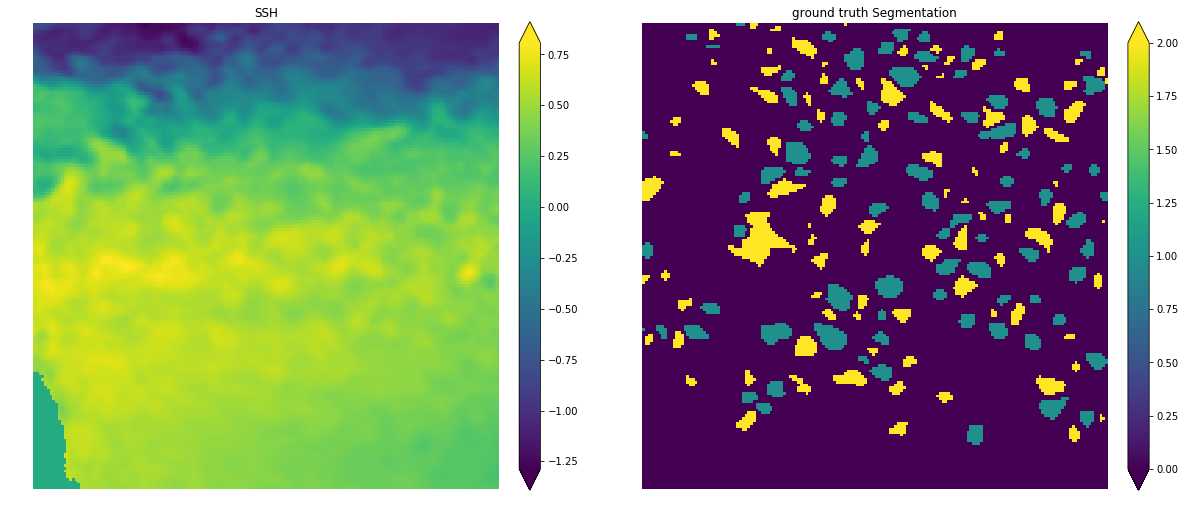

In [3]:
randindex=np.random.randint(0,len(SSH_train))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(122)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## Eddynet 

In [4]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU, add
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

/home/lguensar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
Seg_train_categor = np_utils.to_categorical(np.reshape(Seg_train[:,:,:,0],(4018,168*168)),3)
Seg_train_categor.shape

(4018, 28224, 3)

In [6]:
def ConvBNActi(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1
  
def ConvTranspBNActi(nf,ker,inputs):
    conv1 = Conv2DTranspose(nf, ker, strides=(2, 2), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

In [7]:
width = 168
height = 168
nbClass = 3
nf = 16
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = ConvBNActi(nf,ker,img_input)
conv1 = ConvBNActi(nf,ker,conv1)
conv1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ConvBNActi(nf,ker,pool1)
conv2 = ConvBNActi(nf,ker,conv2)
conv2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ConvBNActi(nf,ker,pool2)
conv3 = ConvBNActi(nf,ker,conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#######################################center

convC = ConvBNActi(nf,ker,pool3)
convC = ConvBNActi(nf,ker,convC)
convC = Dropout(0.5)(convC)

#######################################DECODER

#up3 = concatenate([ConvTranspBNActi(nf,ker,convC), conv3])
up3 = concatenate([UpSampling2D((2,2))(convC), conv3])
decod3 = ConvBNActi(nf,ker,up3)
decod3 = ConvBNActi(nf,ker,decod3)
decod3 = Dropout(0.4)(decod3)



#up2 = concatenate([ConvTranspBNActi(nf,ker,decod3), conv2])
up2 = concatenate([UpSampling2D((2,2))(decod3), conv2])
decod2 = ConvBNActi(nf,ker,up2)
decod2 = ConvBNActi(nf,ker,decod2)
decod2 = Dropout(0.3)(decod2)


#up1 = concatenate([ConvTranspBNActi(nf,ker,decod2), conv1])
up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ConvBNActi(nf,ker,up1)
decod1 = ConvBNActi(nf,ker,decod1)
decod1 = Dropout(0.2)(decod1)


####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

eddynet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 168, 168, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 168, 168, 16) 144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 168, 168, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 168, 168, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### calculate weights (some heavy data imbalance out there...)

In [8]:
unique, counts = np.unique(Seg_train, return_counts=True)
dict(zip(unique, counts))

{0: 100434896, 1: 8225760, 2: 4743376}

In [9]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.02908370281349848, 0.35510623545649606, 0.6158100617300055]

## loss functions

In [10]:
smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.36*dice_coef_anti(y_true, y_pred) + 0.62*dice_coef_cyc(y_true, y_pred) + 0.02*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

In [11]:
eddynet.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss,
                metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

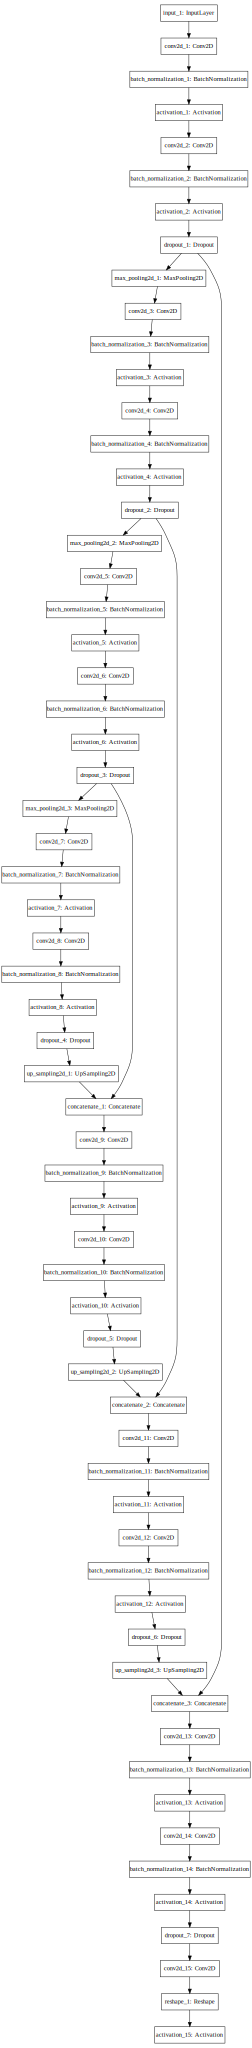

In [12]:
SVG(model_to_dot(eddynet).create(prog='dot', format='svg'))

## Training

In [13]:
modelcheck = ModelCheckpoint('./weights/eddynetfirst.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=50,
                              batch_size=16,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall],#,MyCallback(alpha,beta),reducecall
                              validation_split=0.2
                              )

Train on 3214 samples, validate on 804 samples
Epoch 1/50
3214/3214 [==============================] - 14s 4ms/step - loss: 0.6744 - categorical_accuracy: 0.6407 - mean_dice_coef: 0.4529 - weighted_mean_dice_coef: 0.3256 - val_loss: 0.5891 - val_categorical_accuracy: 0.7625 - val_mean_dice_coef: 0.5440 - val_weighted_mean_dice_coef: 0.4109

Epoch 00001: val_loss improved from inf to 0.58909, saving model to ./weights/eddynetfirst.h5
Epoch 2/50
3214/3214 [==============================] - 9s 3ms/step - loss: 0.4986 - categorical_accuracy: 0.8721 - mean_dice_coef: 0.6360 - weighted_mean_dice_coef: 0.5014 - val_loss: 0.5248 - val_categorical_accuracy: 0.8859 - val_mean_dice_coef: 0.6216 - val_weighted_mean_dice_coef: 0.4752

Epoch 00002: val_loss improved from 0.58909 to 0.52478, saving model to ./weights/eddynetfirst.h5
Epoch 3/50
3214/3214 [==============================] - 9s 3ms/step - loss: 0.4635 - categorical_accuracy: 0.8860 - mean_dice_coef: 0.6647 - weighted_mean_dice_coef: 0.53

3214/3214 [==============================] - 10s 3ms/step - loss: 0.3906 - categorical_accuracy: 0.9068 - mean_dice_coef: 0.7178 - weighted_mean_dice_coef: 0.6094 - val_loss: 0.4242 - val_categorical_accuracy: 0.8805 - val_mean_dice_coef: 0.6908 - val_weighted_mean_dice_coef: 0.5758

Epoch 00023: val_loss did not improve from 0.42255
Epoch 24/50
3214/3214 [==============================] - 10s 3ms/step - loss: 0.3893 - categorical_accuracy: 0.9073 - mean_dice_coef: 0.7189 - weighted_mean_dice_coef: 0.6107 - val_loss: 0.4242 - val_categorical_accuracy: 0.8780 - val_mean_dice_coef: 0.6908 - val_weighted_mean_dice_coef: 0.5758

Epoch 00024: val_loss did not improve from 0.42255
Epoch 25/50
3214/3214 [==============================] - 10s 3ms/step - loss: 0.3883 - categorical_accuracy: 0.9074 - mean_dice_coef: 0.7194 - weighted_mean_dice_coef: 0.6117 - val_loss: 0.4261 - val_categorical_accuracy: 0.8905 - val_mean_dice_coef: 0.6911 - val_weighted_mean_dice_coef: 0.5739

Epoch 00025: val_lo

3214/3214 [==============================] - 10s 3ms/step - loss: 0.3752 - categorical_accuracy: 0.9108 - mean_dice_coef: 0.7287 - weighted_mean_dice_coef: 0.6248 - val_loss: 0.4217 - val_categorical_accuracy: 0.8885 - val_mean_dice_coef: 0.6947 - val_weighted_mean_dice_coef: 0.5783

Epoch 00046: val_loss did not improve from 0.41738
Epoch 47/50
3214/3214 [==============================] - 10s 3ms/step - loss: 0.3749 - categorical_accuracy: 0.9108 - mean_dice_coef: 0.7289 - weighted_mean_dice_coef: 0.6251 - val_loss: 0.4244 - val_categorical_accuracy: 0.8912 - val_mean_dice_coef: 0.6925 - val_weighted_mean_dice_coef: 0.5756

Epoch 00047: val_loss did not improve from 0.41738
Epoch 48/50
3214/3214 [==============================] - 10s 3ms/step - loss: 0.3756 - categorical_accuracy: 0.9104 - mean_dice_coef: 0.7284 - weighted_mean_dice_coef: 0.6244 - val_loss: 0.4186 - val_categorical_accuracy: 0.8901 - val_mean_dice_coef: 0.6974 - val_weighted_mean_dice_coef: 0.5814

Epoch 00048: val_lo

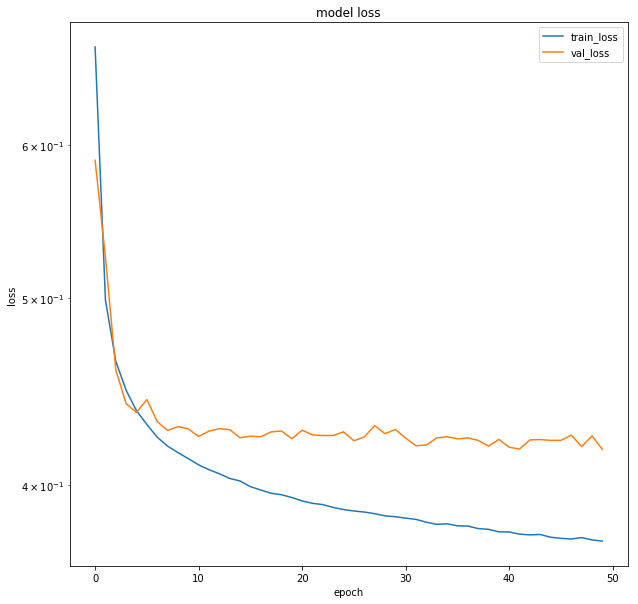

In [14]:
plt.figure(figsize=(10, 10))
plt.semilogy(eddynet.history.history['loss'])
plt.semilogy(eddynet.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

overfitting, huh?... I'm working on that on my next paper, stay tuned! meanwhile for your application you can either get more data or lower the complexity of the architecture (less neurons, less depth..) 

## Performance on train dataset 
just to be sure...

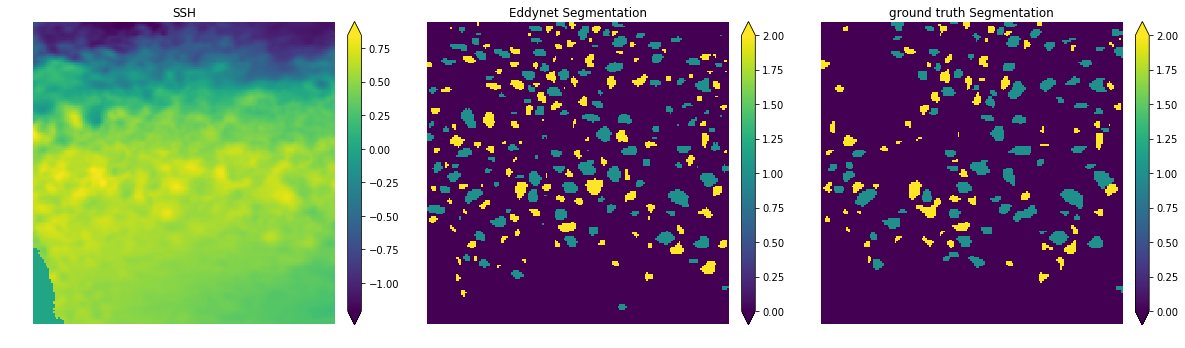

In [21]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## Performance on test dataset (2011 data)

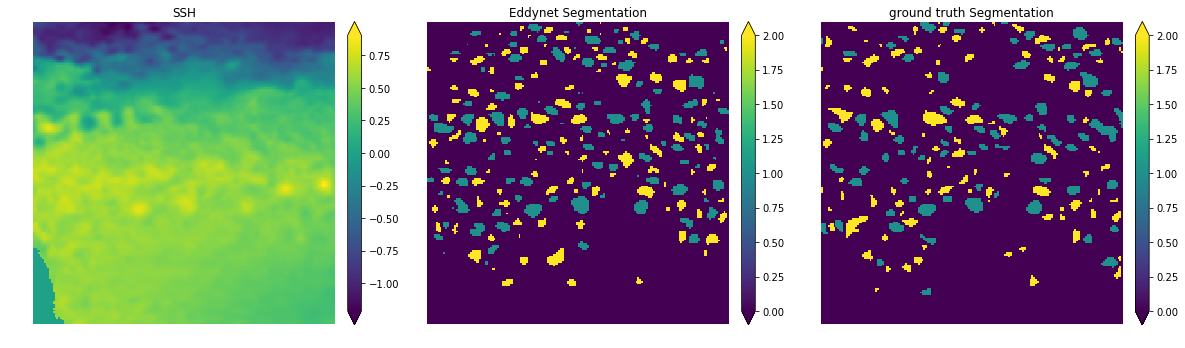

In [20]:
randindex=np.random.randint(0,len(SSH_test))
predictedSEGM=eddynet.predict(np.reshape(SSH_test[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_test[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_test[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

Seems working nicely, but there are some false eddy detections that need to be dealt with, working on it..

In [17]:
#### if you wanna use some animations ;) 


#imageList=[]
#for i in range(1200,1400):
#    imageList.append(SSH_train[i,:,:,0])
  

#print('drawing the animation...')
#from matplotlib import animation, rc
#from IPython.display import HTML

#def getImageFromList(x):
#    return imageList[x]

#fig = plt.figure(figsize=(10, 10))
#ims = []
#for i in range(len(imageList)):
#    im = plt.imshow(getImageFromList(i), animated=True, cmap='viridis')
#    ims.append([im])
#plt.axis('off')

#ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=False)
#plt.close()

#HTML(ani.to_jshtml())